In [1]:
from src.models.base import SklearnWrapper
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from src.data import open_data
from src.metrics import r2_score
import xarray as xr

In [2]:
pwd

'/home/noahb/fv3net/notebooks'

Open the data and split it into a training and testing portion. Also, open the data for lon = 0 to make comparision plots with.

In [3]:
ds = open_data(sources=True)
equator = ds.isel(time=0).sel(grid_xt=0, method='nearest').load()

ds = xr.open_zarr("../data/processed/flattened_.25deg_.25deg.zarr/")

n_train = 50000
n_test = 10000

train = ds.isel(sample=slice(0, n_train)).load()
test = ds.isel(sample=slice(n_train, n_train + n_test)).load()

In [4]:
# Boiler plate for creating a scikit learn model
sklearn_model = TransformedTargetRegressor(
    Ridge(alpha=100.0, normalize=True),
    StandardScaler(),
)
# some custom wrapper code
model = SklearnWrapper(sklearn_model)


# fit a model, predict and compute a score
model.fit(['qv', 'temp', 'pres', 'lhflx', 'shflx', 'fsdt'], ['q1', 'q2'], 'sample', train)
y = model.predict(test, 'sample')
r2s = r2_score(test, y, 'sample')

The validation score is very low for some reason.

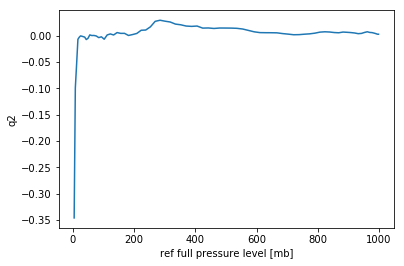

In [5]:
r2s.q2.plot(label='Q2')

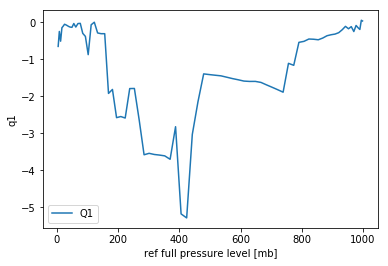

In [6]:
r2s.q1.plot(label='Q1')
plt.legend()

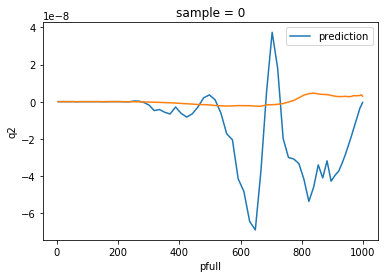

In [7]:
test.q2[0].plot(label='prediction')
y.q2[0].plot()
plt.legend()

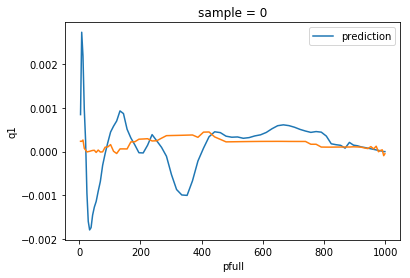

In [8]:
test.q1[0].plot(label='prediction')
y.q1[0].plot()
plt.legend()

# Let's use it to make a prediction

In [9]:
# grid_xt is now the sample dimension
y = model.predict(equator, 'grid_yt')

## Predictions

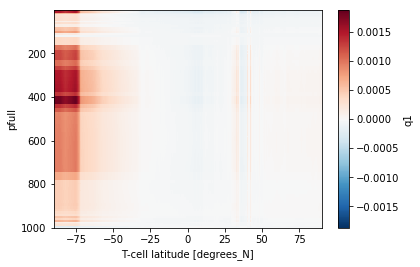

In [10]:
y.q1.plot(x='grid_yt', yincrease=False)

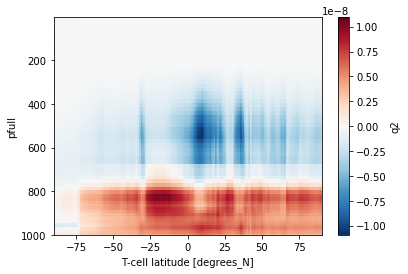

In [11]:
y.q2.plot(x='grid_yt', yincrease=False)

## Truth

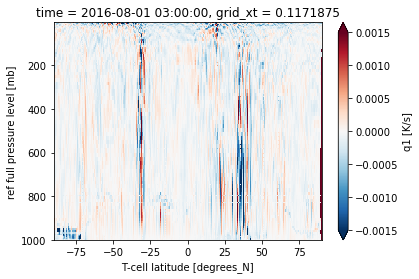

In [12]:
equator.q1.plot(yincrease=False, vmax=.0015)

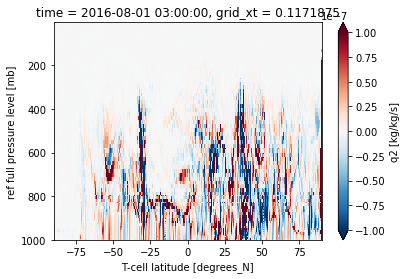

In [13]:
equator.q2.plot(yincrease=False, vmax=1e-7)